## Import lib.

In [2]:
import os
import zipfile

import torch
from torch.utils.data import Dataset , DataLoader
from torchvision import transforms , models
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm



from PIL import Image
import cv2
import matplotlib.pyplot as plt 
import numpy as np 


## Import data

In [3]:
with open(".env") as f:
    for line in f:
        key, val = line.strip().split("=")
        os.environ[key] = val

# print("Kaggle user:", os.environ['KAGGLE_USERNAME'])  
# print("Kaggle user:", os.environ['KAGGLE_KEY'])  

In [3]:
# !kaggle datasets download -d fantacher/neu-metal-surface-defects-data

In [4]:
# with zipfile.ZipFile("neu-metal-surface-defects-data.zip", "r") as zip_ref:
#     zip_ref.extractall("neu_defects")

In [4]:
base_path = r"D:\Metal_surface_defect\neu_defects\NEU Metal Surface Defects Data"
splits = ["train", "test", "valid"]
classes = ["Crazing", "Inclusion", "Patches", "Pitted", "Rolled", "Scratches"]


In [5]:
def get_all_images(base_path, split, classes):
    images = []
    for cls in classes:
        folder = os.path.join(base_path, split, cls)
        images += [os.path.join(folder, img) for img in os.listdir(folder)]
    return images

train_images = get_all_images(base_path, "train", classes)
test_images = get_all_images(base_path, "test", classes)
val_images = get_all_images(base_path, "valid", classes)

print(f"Train images count: {len(train_images)}")
print(f"Test images count: {len(test_images)}")
print(f"Validation images count: {len(val_images)}")

Train images count: 1656
Test images count: 72
Validation images count: 72


## Image Processing 

In [6]:
img = cv2.imread(train_images[276]) #0 - 275 change type

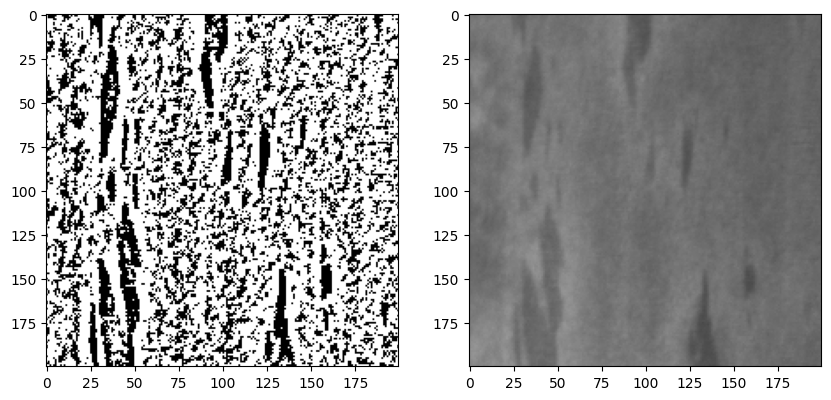

In [7]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
adaptive = cv2.adaptiveThreshold(
    gray,                    # input image (must be 8-bit grayscale)
    255,                        # max value to use with THRESH_BINARY
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,  # adaptive method (or cv2.ADAPTIVE_THRESH_MEAN_C)
    cv2.THRESH_BINARY,          # threshold type
    15,                         # block size (must be odd)
    2                           # C: constant subtracted from mean/weighted mean
)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(adaptive,cmap='gray')
plt.subplot(122)
plt.imshow(img)

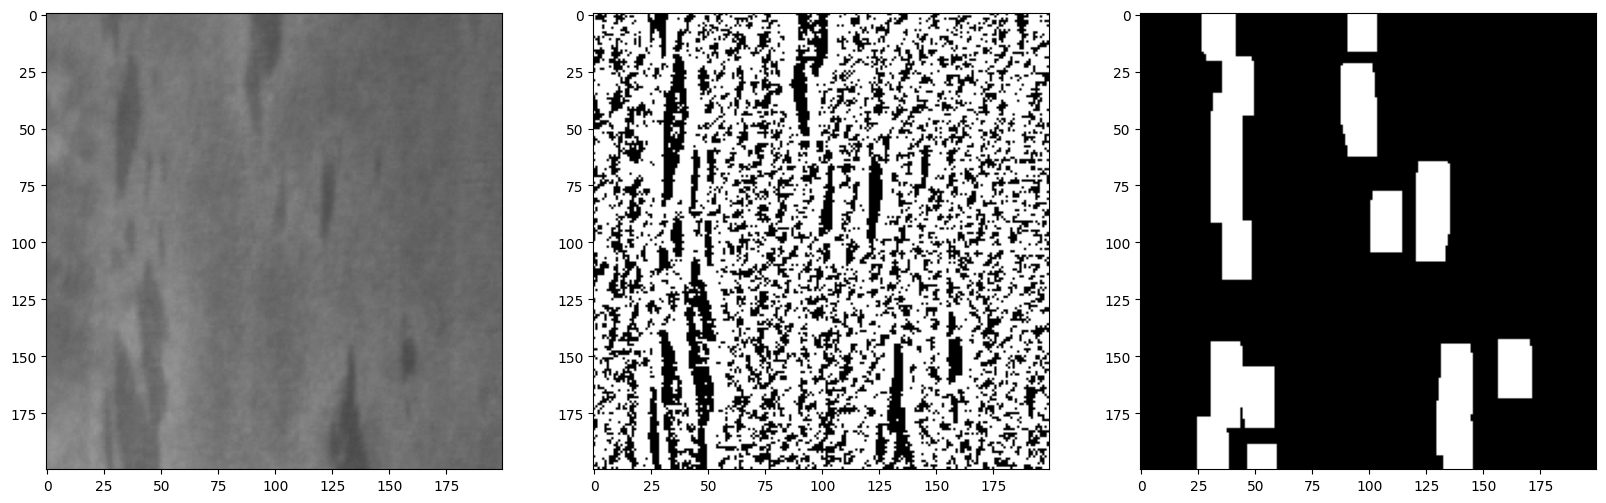

In [8]:
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 13))
vertical_lines = cv2.morphologyEx(adaptive, cv2.MORPH_CLOSE, vertical_kernel, iterations=1)
inverted = cv2.bitwise_not(vertical_lines)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
dilation = cv2.dilate(inverted,kernel,iterations=10)

plt.figure(figsize=(20,20))
plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
plt.imshow(adaptive,cmap='gray')
plt.subplot(133)
plt.imshow(dilation,cmap='gray')

## Create labels

In [9]:
classes = ["Crazing", "Inclusion", "Patches", "Pitted", "Rolled", "Scratches"]
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
class_to_idx

{'Crazing': 0,
 'Inclusion': 1,
 'Patches': 2,
 'Pitted': 3,
 'Rolled': 4,
 'Scratches': 5}

In [10]:
train_images[0]

'D:\\Metal_surface_defect\\neu_defects\\NEU Metal Surface Defects Data\\train\\Crazing\\Cr_120.bmp'

In [11]:
def get_label(image_path):
    for cls in classes:
        if f"\\{cls}\\" in image_path or f"/{cls}/" in image_path:
            return class_to_idx[cls]
    raise ValueError(f"Class not found in path: {image_path}")

In [12]:
train_labels = [get_label(path) for path in train_images]
test_labels = [get_label(path) for path in test_images]
val_labels = [get_label(path) for path in val_images]

In [13]:
print(train_labels[0])
print(train_labels[276])
print(train_labels[552])

0
1
2


## Prepare data

In [14]:
set(train_labels) #number of classes.

{0, 1, 2, 3, 4, 5}

In [15]:
train_images[:5]

['D:\\Metal_surface_defect\\neu_defects\\NEU Metal Surface Defects Data\\train\\Crazing\\Cr_120.bmp',
 'D:\\Metal_surface_defect\\neu_defects\\NEU Metal Surface Defects Data\\train\\Crazing\\Cr_121.bmp',
 'D:\\Metal_surface_defect\\neu_defects\\NEU Metal Surface Defects Data\\train\\Crazing\\Cr_122.bmp',
 'D:\\Metal_surface_defect\\neu_defects\\NEU Metal Surface Defects Data\\train\\Crazing\\Cr_123.bmp',
 'D:\\Metal_surface_defect\\neu_defects\\NEU Metal Surface Defects Data\\train\\Crazing\\Cr_124.bmp']

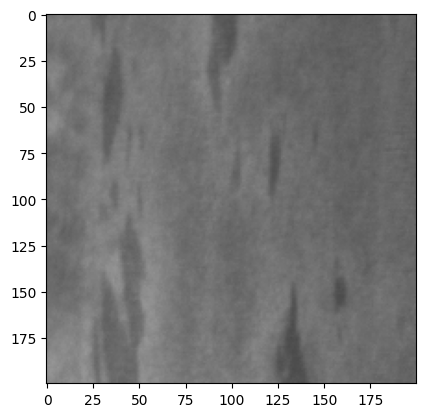

In [16]:
plt.imshow(cv2.imread(train_images[276])) #correct idx

## Data augmentation

In [83]:
base_transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(
#             mean=[0.485, 0.456, 0.406],
#             std=[0.229, 0.224, 0.225]
#         )
# ])
            mean=[0.5, 0.5, 0.5],
            std=[0.5, 0.5, 0.5]
        )
])

    
aug_transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(
            mean=[0.5, 0.5, 0.5],
            std=[0.5, 0.5, 0.5]
        )
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


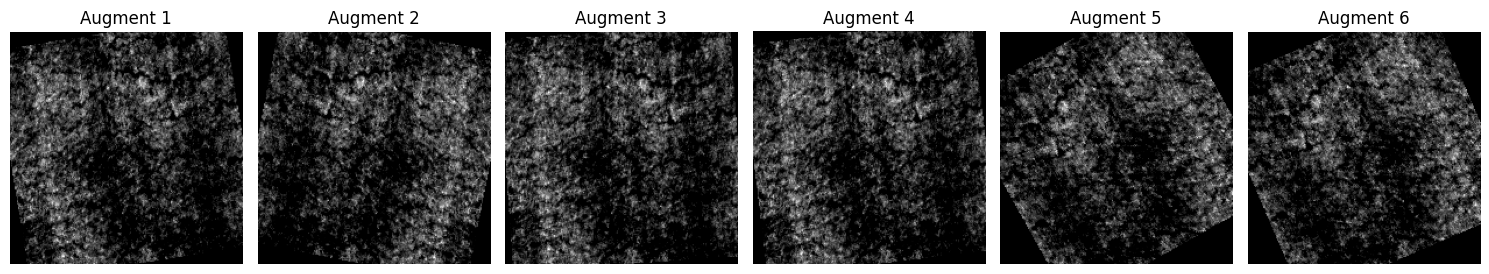

In [84]:
img = Image.open(train_images[0]).convert("RGB")

plt.figure(figsize=(15, 5))
for i in range(6):
    aug_img = aug_transform(img)
    plt.subplot(1, 6, i+1)
    plt.imshow(aug_img.permute(1, 2, 0))  # CHW -> HWC
    plt.axis("off")
    plt.title(f'Augment {i+1}')
plt.tight_layout()
plt.show()

## Dataloader

In [100]:
from collections import Counter
print("Train:", Counter(train_labels))
print("Val:", Counter(val_labels))

Train: Counter({0: 276, 1: 276, 2: 276, 3: 276, 4: 276, 5: 276})
Val: Counter({0: 12, 1: 12, 2: 12, 3: 12, 4: 12, 5: 12})


In [85]:
img = Image.open(train_images[0]).convert("RGB")
img.size

(200, 200)

In [101]:
class FlexibleDataset(Dataset):
    def __init__(self, X, y, base_transform=None, aug_transform=None, 
                 augmentation_ratio=1.0):

        self.x = X
        self.y = y
        self.base_transform = base_transform
        self.aug_transform = aug_transform
        self.augmentation_ratio = augmentation_ratio
        
        # Calculate lengths
        self.original_len = len(self.x)
        self.aug_samples = int(self.original_len * self.augmentation_ratio)
        self.total_len = self.original_len + self.aug_samples
        
        print(f'Original samples: {self.original_len}')
        print(f'Augmented samples: {self.aug_samples}')
        print(f'Total samples: {self.total_len}')
        print("-"*50)

    def __len__(self):
        return self.total_len #importance 

    def __getitem__(self, idx):
        if idx < self.original_len:
            # Original samples
            x = Image.open(self.x[idx]).convert("RGB")
            y = self.y[idx]
            if self.base_transform:
                x = self.base_transform(x)
            return x, y
        else:
            # Augmented samples
            aug_idx = idx % self.original_len
            x = Image.open(self.x[aug_idx]).convert("RGB")
            y = self.y[aug_idx]

            if self.aug_transform:
                x = self.aug_transform(x)
            elif self.base_transform: #prevent not input param.
                x = self.base_transform(x)
            return x, y


In [103]:
train_loader = DataLoader(FlexibleDataset(train_images,train_labels,base_transform=base_transform,aug_transform=aug_transform,augmentation_ratio=0),
                          batch_size=128,shuffle=True)
val_loader = DataLoader(FlexibleDataset(val_images,val_labels,base_transform=base_transform,aug_transform=aug_transform,augmentation_ratio=0),
                          batch_size=32,shuffle=False) #don't need True!!!! because Fair Comparison โมเดลไม่รุ้ดีขึ้นเพราะอะไร 
test_loader = DataLoader(FlexibleDataset(test_images,test_labels,base_transform=base_transform,aug_transform=aug_transform,augmentation_ratio=0),
                          batch_size=32,shuffle=False)


data, labels = next(iter(train_loader))
data.shape

Original samples: 1656
Augmented samples: 0
Total samples: 1656
--------------------------------------------------
Original samples: 72
Augmented samples: 0
Total samples: 72
--------------------------------------------------
Original samples: 72
Augmented samples: 0
Total samples: 72
--------------------------------------------------


torch.Size([128, 3, 200, 200])

## Training

In [104]:
output_size = len(set(train_labels))
output_size

6

## Resnet50

In [105]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False  # freeze all layers

#In Resnet50 FC layer 512 to 1000 class
# Replace layer is 512 to 6 class specific your task.

# num_features = model.fc.in_features
# model.fc = nn.Linear(num_features, output_size)  # for 6 classes

num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(64, output_size)
)

model = model.to(device)
print(model)

d:\mini\envs\object\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\mini\envs\object\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [106]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optim = torch.optim.AdamW(model.fc.parameters(),lr=learning_rate)
n_epoch = 10


In [107]:
train_loss_plot = []
val_loss_plot = []

for epoch in range(n_epoch):
    
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    train_loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{n_epoch}]")
    for inputs , labels in train_loop:
        #setting
        inputs,labels = inputs.to(device) , labels.to(device)
        optim.zero_grad()

        #forward
        outputs = model(inputs)
        loss = criterion(outputs,labels)

        #backward 
        loss.backward()

        #update
        optim.step()

        #keep
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_correct += predicted.eq(labels).sum().item()
        train_total += labels.size(0)

        train_loop.set_postfix(loss=loss.item(), acc=100. * train_correct / train_total)

    epoch_loss = train_loss / len(train_loader)
    train_loss_plot.append(epoch_loss)
    epoch_acc = 100. * train_correct / train_total 


    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0 

    with torch.no_grad():
        # val_loop = tqdm(val_loader,desc='validation')
        for inputs,labels in val_loader:
            #setting 
            inputs,labels = inputs.to(device),labels.to(device)

            #forward 
            outputs = model(inputs)
            loss = criterion(outputs,labels)

            #keep 
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_correct += predicted.eq(labels).sum().item()
            val_total += labels.size(0)

            # val_loop.set_postfix(loss=loss.item(), acc=100. * val_correct / val_total)

    epoch_val_loss = val_loss / len(val_loader)
    epoch_val_acc = 100. * val_correct / val_total
    val_loss_plot.append(epoch_val_loss)
    print(f"Epoch {epoch+1} | train_loss: {epoch_loss:.4f} | val_loss: {epoch_val_loss:.4f} | train_accuracy: {epoch_acc:.2f}%  | val_accuracy: {epoch_val_acc:.2f}%")
    # print(f"Epoch {epoch+1} | train_loss: {epoch_loss:.4f}| val_loss: {epoch_val_loss:.4f}") #We don't should monitoring acc between train val


Epoch [1/10]: 100%|██████████| 13/13 [00:05<00:00,  2.31it/s, acc=25.2, loss=1.66]


Epoch 1 | train_loss: 1.7426 | val_loss: 1.6164 | train_accuracy: 25.18%  | val_accuracy: 51.39%


Epoch [2/10]: 100%|██████████| 13/13 [00:05<00:00,  2.51it/s, acc=47.4, loss=1.15]


Epoch 2 | train_loss: 1.3887 | val_loss: 1.0645 | train_accuracy: 47.40%  | val_accuracy: 50.00%


Epoch [3/10]: 100%|██████████| 13/13 [00:05<00:00,  2.53it/s, acc=69.6, loss=0.554]


Epoch 3 | train_loss: 0.8320 | val_loss: 0.6283 | train_accuracy: 69.57%  | val_accuracy: 81.94%


Epoch [4/10]: 100%|██████████| 13/13 [00:05<00:00,  2.53it/s, acc=81.5, loss=0.385]


Epoch 4 | train_loss: 0.4867 | val_loss: 0.3850 | train_accuracy: 81.46%  | val_accuracy: 86.11%


Epoch [5/10]: 100%|██████████| 13/13 [00:05<00:00,  2.53it/s, acc=90.3, loss=0.395]


Epoch 5 | train_loss: 0.2787 | val_loss: 0.1459 | train_accuracy: 90.34%  | val_accuracy: 94.44%


Epoch [6/10]: 100%|██████████| 13/13 [00:05<00:00,  2.53it/s, acc=93.4, loss=0.158]


Epoch 6 | train_loss: 0.1952 | val_loss: 0.0551 | train_accuracy: 93.42%  | val_accuracy: 97.22%


Epoch [7/10]: 100%|██████████| 13/13 [00:05<00:00,  2.52it/s, acc=94.6, loss=0.155] 


Epoch 7 | train_loss: 0.1461 | val_loss: 0.0532 | train_accuracy: 94.57%  | val_accuracy: 97.22%


Epoch [8/10]: 100%|██████████| 13/13 [00:05<00:00,  2.51it/s, acc=96, loss=0.124]   


Epoch 8 | train_loss: 0.1421 | val_loss: 0.0155 | train_accuracy: 95.95%  | val_accuracy: 98.61%


Epoch [9/10]: 100%|██████████| 13/13 [00:05<00:00,  2.51it/s, acc=97.2, loss=0.0534]


Epoch 9 | train_loss: 0.0982 | val_loss: 0.0016 | train_accuracy: 97.16%  | val_accuracy: 100.00%


Epoch [10/10]: 100%|██████████| 13/13 [00:05<00:00,  2.49it/s, acc=97.6, loss=0.0876]


Epoch 10 | train_loss: 0.0793 | val_loss: 0.0022 | train_accuracy: 97.64%  | val_accuracy: 100.00%


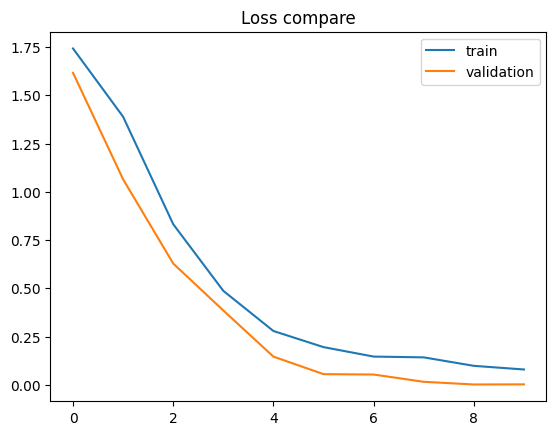

In [110]:
plt.title('Loss compare')
plt.plot(train_loss_plot,label='train')
plt.plot(val_loss_plot,label='validation')
plt.legend() 
plt.show() 

## Test 

In [111]:
model.eval()  # Set model to eval mode
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    test_loop = tqdm(test_loader, desc="Testing")
    for inputs, labels in test_loop:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, predicted = outputs.max(1)
        test_correct += predicted.eq(labels).sum().item()
        test_total += labels.size(0)

        acc = 100. * test_correct / test_total
        test_loop.set_postfix(loss=loss.item(), acc=acc)

final_test_loss = test_loss / len(test_loader)
final_test_acc = 100. * test_correct / test_total

print(f"Final Test Accuracy: {final_test_acc:.2f}% | Test Loss: {final_test_loss:.4f}")

Testing: 100%|██████████| 3/3 [00:00<00:00,  6.16it/s, acc=100, loss=0.0159] 

Final Test Accuracy: 100.00% | Test Loss: 0.0076


## Problem

In [ ]:
#validation and test data are too eazy